# Installing Dependencies

In [39]:
import pandas as pd
from scipy.io import loadmat
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import math
import random 

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report, precision_score, recall_score
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Auxillary Functions

In [40]:
# This function takes the .mat files for exercise 1 and 2. It includes the glove values, emg values, stimulus and restimulus of the patients

def dataset_loader(path, data_per_subject):
  dataset_user = []
  emg_columns = []
  glove_columns = []
  for i in range(12):
    emg_columns.append('emg{}'.format(i+1))
  for i in range(22):
    glove_columns.append('glove{}'.format(i+1))
  for directory_path, directory_names, directory_files in os.walk(path):
    path_training = []
    for files in directory_files:
      path_training.append(os.path.join(directory_path, files))
    for i, path in enumerate(path_training):
      if '.mat' in path and 'E3' not in path:
        Exer = loadmat(path)
        rows = Exer['emg'].shape[0]
        random_indices = np.random.choice(rows, size=data_per_subject, replace=False)
        emg, stimulus, restimulus, glove = Exer['emg'][random_indices], Exer['stimulus'][random_indices], Exer['restimulus'][random_indices], Exer['glove'][random_indices]
        dataset = pd.DataFrame(emg, columns = emg_columns)
        glove = pd.DataFrame(glove, columns = glove_columns)
        dataset[glove_columns] = glove
        stimulus = pd.DataFrame(stimulus)
        restimulus = pd.DataFrame(restimulus)
        dataset['stimulus'] = stimulus
        dataset['restimulus'] = restimulus
        dataset_user.append(dataset)
  dataset = pd.concat(dataset_user, axis = 0).sample(frac = 1.0, random_state = 42).reset_index(drop = True)
  return dataset

In [41]:
# This is used to visualize the count of unique values in a given pandas column

def count_visualizer(dataset, col_name):
    data = dataset
    fig, ax = plt.subplots()
    ax.hist(data[col_name])
    ax.set_title('Frequency of Unique Values')
    ax.set_xlabel('Unique Value Label')
    ax.set_ylabel('Count')

In [42]:
# This is to get an array of (stimulus, stimulus_count) in the dataset

def stimulus_count(data, column):
    stim_count = []
    stim = data[column].unique()
    for i in range(len(stim)):
        stim_count.append([stim[i], np.count_nonzero(data[column] == stim[i])])
        
    return stim_count

In [43]:
# This is used to find the number of features that have a correlation factor greater than a threshold compared to other features
# To get an array of the columns, set get_cols = True

def correlation_counter(dataset, features, correlation_threshold, count_limit, get_cols = False):
    if get_cols == False:
        print("Feature: (Correlation > {}) count".format(correlation_threshold))
    EMG_data_correlation = dataset[features].corr()
    columns = []
    for y in range(len(EMG_data_correlation)):
        cr_count = 0
        for x in EMG_data_correlation[features[y]]:
            if abs(x) > correlation_threshold:
                cr_count += 1
        if (cr_count - 1) > count_limit and get_cols == False:
            print(f"    {features[y]}: {cr_count - 1}")   
        if (cr_count - 1) > count_limit and get_cols == True:
            columns.append(features[y])
    if get_cols == True:
        return columns

# Dataset Procurement

In [44]:
# Data is taken from 11 subjects, this code also includes an option to take data from random number of subjects
# sEMG, glove, stimulus, restimulus data is taken
# Link to dataset: http://ninapro.hevs.ch/node/132

index = []
subject_count = 11
start_index = 1     #always = 1 by default
data_per_subject = 30000
data = []

for i in range(subject_count):
    index.append('{}'.format(i+start_index))

path = [["Datasets/s" + i + "_0/DB3_s" + i] for i in index]
for i, path in enumerate(path):
    data.append(dataset_loader(path[0], data_per_subject = data_per_subject))

dataset = pd.concat(data, axis = 0).sample(frac = 1.0, random_state = 42).reset_index(drop = True)
columns = dataset.columns
features = columns[:-2]
target = columns[-2:]

[[0, 257271], [9, 12143], [27, 9379], [35, 7843], [4, 12064], [11, 12204], [14, 12085], [33, 7819], [40, 7742], [15, 11900], [1, 12041], [29, 9429], [16, 12079], [34, 7810], [23, 9289], [12, 12153], [18, 9202], [21, 9317], [32, 7667], [24, 9286], [36, 7863], [20, 9111], [2, 12120], [38, 7979], [8, 12095], [5, 11808], [28, 9265], [19, 9342], [39, 7714], [10, 11942], [26, 9333], [13, 12339], [31, 7762], [3, 12174], [6, 12191], [22, 9097], [7, 11909], [25, 9307], [17, 12303], [37, 7729], [30, 7894]]




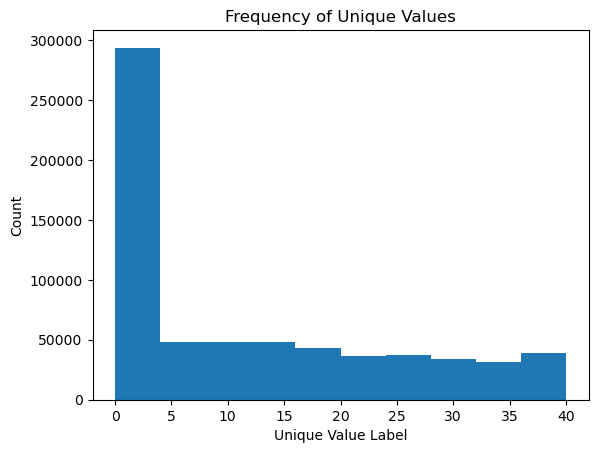

In [45]:
# This gives the stimulus values and their counts

stim_count = stimulus_count(dataset, target[0])
print(stim_count)
print('\n')
count_visualizer(dataset, target[0])

In [46]:
#Check for missing/zero data in the features:

missing_count = (dataset[features].isnull().sum())/(len(dataset[features]))
print(f"Number of features: {len(features)}")
print(f"Number of features without missing/zero data: {missing_count.isnull().count()}")

Number of features: 34
Number of features without missing/zero data: 34


<Axes: >

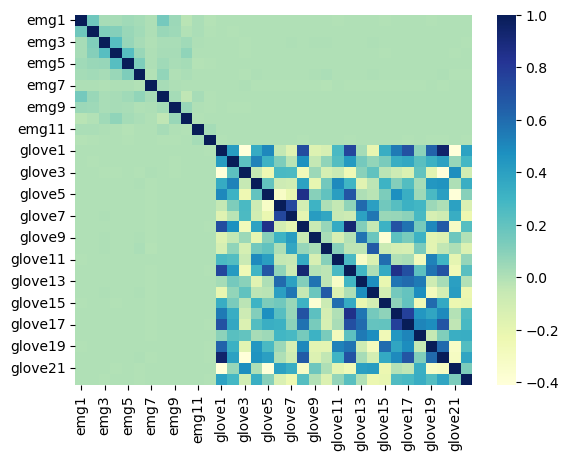

In [47]:
#Check Correlation between the features using heatmap:

EMG_data_correlation = dataset[features].corr()
sns.heatmap(EMG_data_correlation, cmap = 'YlGnBu')

In [48]:
#Check number of occurences of Correlation > 0.75 between the features:
#This can be used to eliminate features that behave similar to other features thus reducing computational power requirements

correlation_counter(dataset, features, correlation_threshold = 0.75, count_limit = 1, get_cols = False)

Feature: (Correlation > 0.75) count
    glove8: 2
    glove12: 2
    glove16: 2


# Dataset Preprocessing

In [49]:
#Feature selection based on correlation count:
#Remove features if number of (correlation > 0.75) count > 1:

columns_to_drop = correlation_counter(dataset, features, correlation_threshold = 0.75, count_limit = 1, get_cols = True)
dataset = dataset.drop(columns_to_drop, axis = 1)

columns = dataset.columns
features = columns[:-2]
target = columns[-2:]
print('Shape of Dataset after elimination: {}'.format(dataset.shape))

Shape of Dataset after elimination: (660000, 33)


In [50]:
# Row deduction based on whether stimulus == restimulus for securing stronger data for training

indexes = dataset[(dataset['stimulus'] != dataset['restimulus'])].index
dataset.drop(indexes, inplace = True)
print('Shape of Dataset after elimination: {}'.format(dataset.shape))

Shape of Dataset after elimination: (555467, 33)


In [51]:
# Row deduction based on which stimuli to keep for model training

stim = dataset[target[0]].unique()
functional_movement = stim[stim > 17]
isometric_movement = stim[stim < 9]
wrist_movement = stim[(stim > 8) & (stim < 18)]

#stimulus_to_keep = [41, 42, 43, 44, 45, 46]          #Keep selective stimuli
stimulus_to_keep = isometric_movement                 #Keep all the stimuli
for i in range(len(stimulus_to_keep)):
    indexes_2 = dataset[~(dataset['stimulus'].isin(stimulus_to_keep))].index
    dataset.drop(indexes_2, inplace = True)
print('Shape of Dataset after elimination: {}'.format(dataset.shape))

Shape of Dataset after elimination: (293241, 33)


In [52]:
# Row deduction based on uneven distribution of stimulus data (rest position / stimulus = 0)

stim_count = stimulus_count(dataset, target[0])
for i, z in stim_count[:]:
    if i in stimulus_to_keep:
        if i == 0:
            indexes_3 = dataset[(dataset[target[0]] == 0)].index
            total_count_without0 = 0
            for i in range(len(stim_count)):
                if stim_count[i][0] == 0:
                    continue
                else:
                    total_count_without0 += stim_count[i][1]
            average_without_zero = math.ceil(total_count_without0 / (len(stim_count) - 1))
            indexes_3 = random.sample(list(indexes_3), len(dataset[dataset[target[0]] == 0]) - average_without_zero)
            indexes_3 = pd.Index(indexes_3, dtype = 'Int64')
            dataset.drop(indexes_3, inplace = True)
print('Shape of Dataset after elimination: {}'.format(dataset.shape))

Shape of Dataset after elimination: (94201, 33)


In [53]:
# Normalize the data between -1 and 1

for i in range(len(features)):
  dataset[features[i]] /= np.max(np.abs(dataset[features[i]]))

In [54]:
# Dataset loading for the models

x = dataset.iloc[:, :-2]
y = dataset[target[0]]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, 
                                                    random_state = 39, shuffle = True)

print("Shape of x_train: {}\nShape of y_train: {}\nShape of x_test: {}\nShape of y_test: {}".format(x_train.shape,
                                                                                                   y_train.shape,
                                                                                                   x_test.shape,
                                                                                                   y_test.shape))

Shape of x_train: (75360, 31)
Shape of y_train: (75360,)
Shape of x_test: (18841, 31)
Shape of y_test: (18841,)


# Machine Learning Models

#### Decision Tree Algorithm

In [55]:
# Call the Decision Tree model and evaluate the accuracy on test data

DT_model = tree.DecisionTreeClassifier(
              criterion = "entropy",
              min_samples_leaf = 3,
              min_samples_split = 4,
              random_state = 32,
              splitter = 'best')

DT_model.fit(x_train, y_train)
y_pred_DT = DT_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred_DT)
print(f"Accuracy is: {accuracy * 100}")

Accuracy is: 63.25566583514676


#### K-Nearest-Neighbour Classifier

In [56]:
# Call the KNN model and evaluate the accuracy on test data

KNN_model = KNeighborsClassifier(algorithm = 'kd_tree',
                                            leaf_size = 150,
                                            metric = 'euclidean',
                                            n_jobs = -1,
                                            n_neighbors = 3,
                                            p = 2,
                                            weights = 'distance')

KNN_model.fit(x_train, y_train)
y_pred_KNN = KNN_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred_KNN)
print(f"Accuracy is: {accuracy * 100}")

Accuracy is: 52.99081789713922
